## Text Summarization using the Gensim summarizer module

This is a simple method to tackle the problem of text summarization, it is an extractive approach which select sentences from the corpus that best represent it and arrange them to form a summary. *Extractive summary extract the important and meaningful sentences from the original text and placing them into summary without any changes* [1].
As described in an excellent paper about extractive summarization, cited in the references section: 

*Extractive techniques generally generate summaries through 3 phases or it essentially based on them. These phases are preprocessing step,
processing step and generation step:
1) Preprocessing step: the representation space dimensionality of the original text is reduced to involve a new structure representation. It usually includes:

    a. Stop-word elimination: Common words without semantics that do not collect information relevant to the task (for example, "the", "a", "an", "in") are eliminated.
    
    b. Steaming: Acquire the stem of each word by bringing the word to its base form.
    
    c. Part of speech tagging: The process of identifying and classifying words of the text on the basis of part of speech category they belong (nouns, verbs, adverbs, adjectives).
    
2) Processing step: It uses an algorithm with the help of features generated in the preprocessing step to convert the text structure to the summary structure. In which, the sentences are scored.

3) Generation step: sentences are ranked. Then, it pick up the most important sentences from the ranked structure to generate the final required summary.*

These techniques are very popular in the industry as they are very easy to implement. They use existing natural language phrases and are reasonably accurate. And they are very fast since they are an unsupervised algorithm, so they do not have to calculate loss function in every step.


### Installing and importing the libraries

In [ ]:
#Install the gensim package for the first time only
#!pip install gensim

I will use the rouge library to calculate the ROUGE metrics to evaluate the results.This library is independant from the "official" ROUGE script (aka. ROUGE-155) and results may be slighlty different,but it is very easy to use.


In [70]:
#!pip install rouge

In [1]:
# Import the utils and libraries
import pandas as pd
import numpy as np
import random
import os
# Import libraries to plot results
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Load the gensim modules
from gensim.summarization import summarize
from gensim.summarization import keywords
from gensim.summarization.textcleaner import split_sentences
from gensim.summarization import summarizer

#Module for splitting the dsataset
from sklearn.model_selection import train_test_split
#Import library to calculate the evaluation metric
from rouge import Rouge


Define some global variables

In [2]:
# Define the data path for input and output data
data_path='MLE_Capstone_Text_Summarization/data'
output_path='MLE_Capstone_Text_Summarization/data'

# Define the train and validation datafiles
traindata_file= 'cl_train_news_summary.csv'
validdata_file= 'cl_valid_news_summary.csv'
train_filename = os.path.join(data_path, traindata_file)
valid_filename = os.path.join(data_path, validdata_file)

# Set the output data path and filenames for the train and validation datasets  
train_results='gensim_output_'+traindata_file
valid_results='gensim_output_'+validdata_file
train_results_filename = os.path.join(output_path, train_results)
valid_results_filename = os.path.join(output_path, valid_results)

# Set the desire length for the summarize to produce
# This variables can be adjusted depending on the legnth of the source text and the length of the desired summary.
summary_length = 0.2

### Load the dataset

In [ ]:
# Run only when new datafiles have been stored in GS
#%%bash
#gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

Removing the examples with null values or duplicates

In [3]:
def clean_dataframe(df):
    ''' Clean the dataframe removing duplicate rows, rows with null values and rename the columns'''
    #Drop duplicate rows
    df.drop_duplicates(subset=["text"],inplace=True)
    #Drop rows with null values in the text variable
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    # we are using the text variable as the summary and the ctext as the source text
    df.columns = ['summary','text']
    
    return df

In [4]:
#Load the train dataset into a pandas dataframe
train_df = pd.read_csv(train_filename, encoding='utf-8')
train_df.head(5)
#Load the validation dataset into a pandas dataframe
valid_df = pd.read_csv(valid_filename, encoding='utf-8')
# Clean the dataframes
train_df = clean_dataframe(train_df)
valid_df = clean_dataframe(valid_df)

valid_df.head(5)

,summary,text
0,amid reports mass layoffs former infosys cfo v...,hyderabad may 30 pti employees unions needed i...
1,following demise aiadmk supremo j jayalalithaa...,demise aiadmks permanent general secretary j j...
2,british government must hold vote houses parli...,government lost fasttracked appeal supreme cou...
3,leader political party puthiya tamizhagam thre...,kamal haasan bigg boss tamil involved yet anot...
4,journalists barred access wife recently deceas...,chinese authorities claim liu xia free woman ....


## Build the summarizer with gensim

This method consist in invoke the module *summarize* from the gensim library, seting the summary length as the ratio of sentences from the source text we want in the summary.

In [5]:
#Set the desire length for the summarize to produce
# This variables can be adjusted depending on the legnth of the source text and the length of the desired summary.
summary_length = 0.2

In [6]:
def generate_summary(data_text, ratio):
    ''' Generate a summary for every element in the data_text using the
        gensim summarizer method.
        
        Input:
           - data_text: list of strings to summarize
           - summary_lenght: how many words will the summary contain
        Output:
           - A list of strings, the summary for every string in the data_text input
           - errors: number of strings that can not be summarize
           - no_summarizables: number of strings 
    '''
    
    summaries=[]
    errors=0
    no_summarizable=0
    empty=0
    # Set the minimun number of sentences in a text to be summarize
    summarizer.INPUT_MIN_LENGTH = 2
    # for every string in the input list
    for i, source_text in enumerate(data_text):
        # if the number of sentences in the source text is less thsn 1 
        #it can not be summarize
        if len(split_sentences(source_text))> 1:
            try:
                # Call gensim summarize to get a summarization with summary length words
                summary = summarize(source_text, ratio = ratio)
                if summary!="":
                    summaries.append(summarize(source_text, ratio = ratio))
                else:
                    # If the summary is empty insert a especial token
                    summaries.append('<EMPTY>')
                    empty +=1
                   
            except:
                # Sometimes the sentences in the surce text are not correct
                # to produce a summary
                summaries.append('<ERROR>')
                errors +=1
        else:
            # Set the summary as No summarizable because the text is too short
            summaries.append('<NO SUMMARIZABLE>')
            no_summarizable +=1

    return summaries, errors, no_summarizable, empty


The next section of code will generate a summary using the gensim library

In [7]:
# Generate the summaries for the data and test set
print("\nGenerating the summary for the train set\n")
train_preds,errors, no_summarizable, empty =generate_summary(train_df['text'].values, summary_length)
print('Errors: ',errors)
print('No Summarizable: ',no_summarizable)
print('Empty: ',empty)
print("\nGenerating the summary for the test set\n")
test_preds,errors, no_summarizable, empty=generate_summary(valid_df['text'].values, summary_length)
print('Errors: ',errors)
print('No Summarizable: ',no_summarizable)
print('Empty: ',empty)


Generating the summary for the train set

Errors:  0
No Summarizable:  171
Empty:  697

Generating the summary for the test set

Errors:  0
No Summarizable:  27
Empty:  116


Lets explore some of them summaries we have extracted:

In [8]:
import random
#Print some summaries to analyze them
print('Examples: \n')
for i in random.sample(range(50),10):
    print('i: ',i,' : ', test_preds[i],'\n')
    

Examples: 

i:  9  :  <EMPTY> 

i:  47  :  jdu hitting prime minister said spurt incidents lynching killing name gau raksha across country bjp government made cow national agenda seeking polarising votes.speaking india today jdu spokesperson neeraj kumar said pm modi interested votes name cow rather gau seva.pm appeal gau rakshaks second time kill people name cow . 

i:  33  :  seems fallen deaf ears.meanwhile prime minister modi also expressed concern 22 mp votes declared invalid recent presidential elections . 

i:  1  :  next day aiadmks senior leader madhusudhanan along another senior leader sengottaiyan went poes garden seemed pleaded sasikala accept partys general secretary post . 

i:  45  :  <NO SUMMARIZABLE> 

i:  22  :  result national leagues tough time attracting crowds stand coupled common excuse standard football.india continue 2019 afc asian cup qualification campaign tuesday kyrgyz republic sree kanteerava stadium bengaluru . 

i:  36  :  young artists embarked pursuits

Once we have inspected the results we observed that there are three kind of errors or incoherent results: 
- Errors, when the gensim summarizer produce an error
- No summarizable, when the summarizer can not applyied because of the number of sentences
- Null, when the summary obtained is empty or null


### Evaluating the results using ROUGE metrics 

To evaluate the model, we will use the ROUGE metric:
*ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.*.


#### Create predicted and real summaries file

Next, we define some function to help us evaluate the metrics on the results

In [9]:
def eval_metrics(preds, targets, avg=True):
    ''' Evaluate the ROUGE metrics ROUGE-2 and ROUGE-L for every pair predicted summary - target summary
    
        Input:
           - preds: list of strings, predicted summaries
           - targets: list of string, target summaries
        Output:
            - rouge2_f_metric: list of float, the Rouge-2 fscore for every predicted summary
            - rougel_f_metric: list of float, the Rouge-L fscore for every predicted summary
    '''
    #Lets calculate the rouge metrics for every document
    rouge = Rouge()
    scores = rouge.get_scores(preds, targets, avg)
    # Create the output variables
    if avg:
        rouge2_f_metric = scores['rouge-2']['f']
        rouge2_p_metric = scores['rouge-2']['p']
        rouge2_r_metric = scores['rouge-2']['r']
        rougel_f_metric = scores['rouge-l']['f']
        rougel_p_metric = scores['rouge-l']['p']
        rougel_r_metric = scores['rouge-l']['r']
    else:
        rouge2_f_metric = [score['rouge-2']['f'] for score in scores]
        rouge2_p_metric = [score['rouge-2']['p'] for score in scores]
        rouge2_r_metric = [score['rouge-2']['r'] for score in scores]
        rougel_f_metric = [score['rouge-l']['f'] for score in scores]
        rougel_p_metric = [score['rouge-l']['p'] for score in scores]
        rougel_r_metric = [score['rouge-l']['r'] for score in scores]

       
    
    return rouge2_f_metric, rouge2_p_metric, rouge2_r_metric, rougel_f_metric, rougel_p_metric, rougel_r_metric

def save_to_df(text, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r):
    ''' Stores the metric results into a pandas dataframe'''
    results = pd.DataFrame(columns=['text', 'summary','pred_summary','rouge2-f','rouge2-p','rouge2-r','rougel-f', 'rougel-p', 'rougel-r'])
    results['text'] = text
    results['summary'] = labeled_summaries
    results['pred_summary'] = predicted_summaries
    results['rouge2-f'] = r2_f
    results['rouge2-p'] = r2_p
    results['rouge2-r'] = r2_r
    results['rougel-f'] = rl_f
    results['rougel-p'] = rl_p
    results['rougel-r'] = rl_r
 
    return results

We will call the previous function to calculate the metrics and prepare the results. We evaluate the **traning dataset**:

In [10]:
#Create the list of predicted summaries
predicted_summaries = train_preds
#Create the list of targeted summaries
labeled_summaries = list(train_df['summary'].values)
#Calculate the metrics
r2_f, r2_p, r2_r, rl_f, rl_p, rl_r = eval_metrics(predicted_summaries, labeled_summaries, False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))
#Save the predictions and metrics in a file 
train_results = save_to_df(train_df['text'].values, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r)
train_results.to_csv(train_results_filename, index=False)
train_results.head(5)

Mean Rouge-2 FScore:  0.10755085068293661 Mean Rouge-L FScore:  0.22154636704397204


,text,summary,pred_summary,rouge2-f,rouge2-p,rouge2-r,rougel-f,rougel-p,rougel-r
0,samsung galaxy note fan waiting hear words not...,south korean tech giant samsung refuted report...,report samsung planning sell refurbished galax...,0.145455,0.235294,0.105263,0.375000,0.562500,0.281250
1,public works department pwd cleared proposal c...,public works department pwd approved construct...,nh58 denotified highway last year assigned dis...,0.091743,0.067568,0.142857,0.170213,0.131148,0.242424
2,new delhi jun 30 pti india transits new era ro...,central board excise customs cbec friday annou...,enable availability officers staff benefit tra...,0.000000,0.000000,0.000000,0.160000,0.142857,0.181818
3,new delhi aug 2 pti bomb squads canine teams t...,bomb squads canine teams rushed check package ...,<EMPTY>,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,newcomer kuldeep yadav picked four wickets deb...,indian spinner kuldeep yadav registered 468 de...,newcomer kuldeep yadav picked four wickets deb...,0.038462,0.030769,0.051282,0.164948,0.131148,0.222222


We will repeat the steps for the **validation dataset** to save the results on disk

In [13]:
#Create the list of predicted summaries
predicted_summaries = test_preds
#Create the list of targeted summaries
labeled_summaries = list(valid_df['summary'].values)
#Calculate the metrics
r2_f, r2_p, r2_r, rl_f, rl_p, rl_r = eval_metrics(predicted_summaries, labeled_summaries, False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))
#Save the predictions and metrics in a file 
valid_results = save_to_df(valid_df['text'].values, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r)
valid_results.to_csv(valid_results_filename, index=False)
valid_results.head(5)

Mean Rouge-2 FScore:  0.11318916800501455 Mean Rouge-L FScore:  0.23051210583233367


,text,summary,pred_summary,rouge2-f,rouge2-p,rouge2-r,rougel-f,rougel-p,rougel-r
0,hyderabad may 30 pti employees unions needed i...,amid reports mass layoffs former infosys cfo v...,hyderabad may 30 pti employees unions needed i...,0.162162,0.112500,0.290323,0.372093,0.271186,0.592593
1,demise aiadmks permanent general secretary j j...,following demise aiadmk supremo j jayalalithaa...,next day aiadmks senior leader madhusudhanan a...,0.067797,0.095238,0.052632,0.259259,0.350000,0.205882
2,government lost fasttracked appeal supreme cou...,british government must hold vote houses parli...,government lost fasttracked appeal supreme cou...,0.012780,0.007168,0.058824,0.134615,0.080000,0.424242
3,kamal haasan bigg boss tamil involved yet anot...,leader political party puthiya tamizhagam thre...,kamal haasan bigg boss tamil involved yet anot...,0.271186,0.320000,0.235294,0.338983,0.384615,0.303030
4,chinese authorities claim liu xia free woman ....,journalists barred access wife recently deceas...,one week death husband nobel laureate democrac...,0.054795,0.032967,0.162162,0.157068,0.094340,0.468750


There are two aspects that may impact the need for human post-processing:
- Does the summary sound fluent?
- Is summary adequate? I.e. is the length appropriate and does it cover the most important information of the text it summarizes?

ROUGE doesn't try to assess how fluent the summary: ROUGE only tries to assess the adequacy, by simply counting how many n-grams in your generated summary matches the n-grams in your reference summary (or summaries, as ROUGE supports multi-reference corpora).This is the process for one document-summary pair. You repeat the process for all documents, and average all the scores and that gives you a ROUGE-N score. So a higher score would mean that on average there is a high overlap of n-grams between your summaries and the references.

Example:

S1. police killed the gunman
S2. police kill the gunman
S3. the gunman kill police

S1 is the reference and S2 and S3 are candidates. Note S2 and S3 both have one overlapping bigram with the reference, so they have the same ROUGE-2 score, although S2 should be better. An additional ROUGE-L score deals with this, where L stands for Longest Common Subsequence. In S2, the first word and last two words match the reference, so it scores 3/4, whereas S3 only matches the bigram, so scores 2/4. See the paper for more details

Because ROUGE is based only on content overlap, it can determine if the same general concepts are discussed between an automatic summary and a reference summary, but it cannot determine if the result is coherent or the sentences flow together in a sensible manner. High-order n-gram ROUGE measures try to judge fluency to some degree.

**What is the best way to really understand what a ROUGE score actually measures?**

In short and approximately:

ROUGE-n recall=40% means that 40% of the n-grams in the reference summary are also present in the generated summary.
ROUGE-n precision=40% means that 40% of the n-grams in the generated summary are also present in the reference summary.
ROUGE-n F1-score=40% is more difficult to interpret, like any F1-score.
ROUGE is more interpretable than BLEU (from {2}: "Other Known Deficiencies of Bleu: Scores hard to interpret"). I said approximately because the original ROUGE implementation from the paper that introduced ROUGE {3} may perform a few more things such as stemming.

## Visualization of results

Plotting the distribution of the Rouge-2 and Rouge-L values in the training data

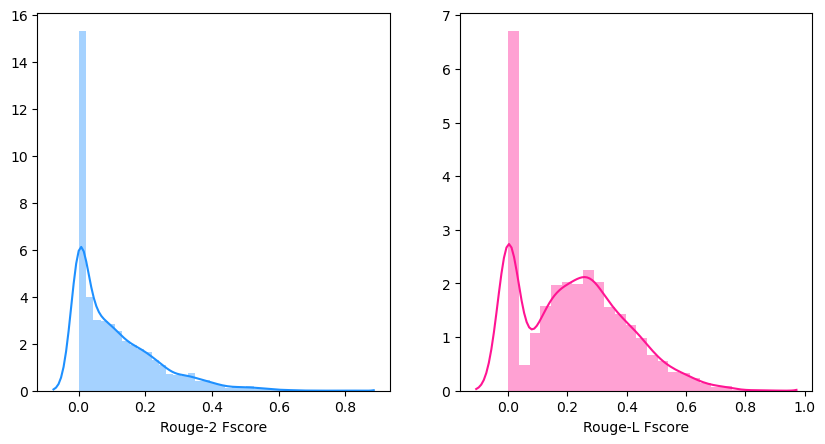

In [14]:
# Define the arguments for plotting
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# Plot a histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, dpi=100)
sns.distplot(train_results['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(train_results['rougel-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')

Plotting the distribution of the Rouge-2 values in the validation data

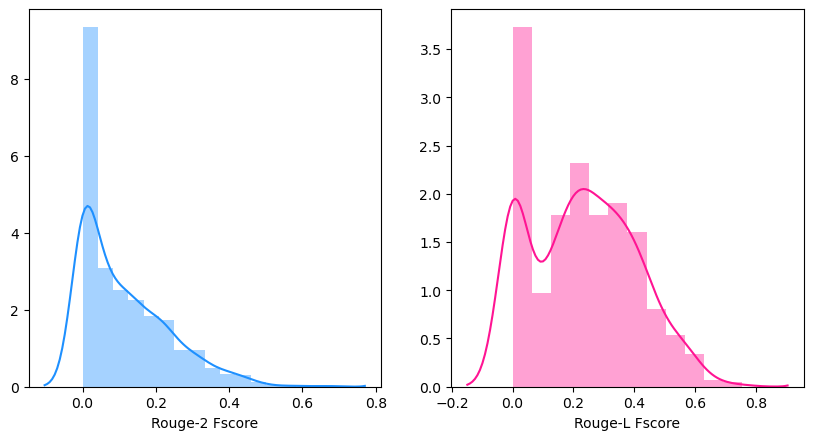

In [15]:
# Define the arguments for plotting
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# Plot a histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, dpi=100)
sns.distplot(valid_results['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(valid_results['rougel-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')

#### References

[1]. El-Refaiy, Ahmed & Abas, A.R. & Elhenawy, I.. (2018). Review of recent techniques for extractive text summarization. Journal of Theoretical and Applied Information Technology. 96. 7739-7759. 


[2] Lin, Chin-Yew. "Rouge: A package for automatic evaluation of summaries." In Text summarization branches out: Proceedings of the ACL-04 workshop, vol. 8. 2004. https://scholar.google.com/scholar?cluster=2397172516759442154&hl=en&as_sdt=0,5 ; http://anthology.aclweb.org/W/W04/W04-1013.pdf